In [1]:
cd MF

/home/shse/Documents/sim_mf_bonne/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [73]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=4 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=2

p_con=np.ones((4,4))*(0.05)#np.ones((4,4))*(0.05) ou number_of_pop*0.05
delays=np.zeros((4,4))*(0.05)
#p_con[2][2]=0.6 #inh tres connecté 
p_con[0][3]=p_con[1][2]=p_con[2][3]=p_con[3][2]=0 ## the two FS populations are not connected !
p_pois=np.ones(4)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0,0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[1,1,1e-3,1e-3] # tau_w
params['a']=[0,0,0,0] # a 0,0
params['b']=[60e-12,60e-12,0,0] # b 
#params['w']=[10e-12,10e-12,0,0]
params['El']=[-70e-3,-70e-3,-65e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,8000,2000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1.5e-9 # Qe à 2e-9 par vers 200Hz
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9,10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3,-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12,200e-12,200e-12]


params['delays']=delays

params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[0.8,0.8,0.8,0.8] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=2# numb_sub_exc
params['numb_sub_inh']=2# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0, 0, 0], 'tstep': 0.0005, 'numb_var': 22, 'tauw': [1, 1, 0.001, 0.001], 'a': [0, 0, 0, 0], 'b': [6e-11, 6e-11, 0, 0], 'El': [-0.07, -0.07, -0.065, -0.065], 'total_size': 10000, 'size_subpop': [8000, 8000, 2000, 2000], 'numb_pop': 4, 'numb_adapt': 2, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1.5e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08, 1e-08, 1e-08], 'Vthre': [-0.05, -0.05, -0.05, -0.05], 'Cm': [2e-10, 2e-10, 2e-10, 2e-10], 'delays': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f299ad9f280>, 'ext_inp': [0.8, 0.8, 0.8, 0.8], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 2, 'numb_sub_inh': 2, 'p_conn': array([[0.05, 0.05, 0.05, 0.  ],
       [0.05, 0.05, 0.  , 0.05],
       [0.05, 0.05, 0.05, 0.  ],
       [0.05, 0.05, 0.  , 0.05]]), 'p_pois': array([0.05, 0.05, 0.05, 0.05])}


In [74]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'
#NRN3='RS-cell'
#NRN4='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp_2 = load_transfer_functions_with_ALL_params_ij(NRN1, NRN2, NTWK,par,1,3)
 # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[0],TF_temp[1],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


### Integration of the MF equations with delays

##### Straight to second order !

In [75]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5

x0=np.ones(params['numb_var'])*1e-5 
x0[0]=0.6 #ve1 exp 
x0[1]=0.6 #ve2 exp
x0[2]=7.0 #vi1 exp 
x0[3]=7.0 #vi2 exp
x0[20]=x0[0]*60e-12 #x0[0]*60e-12 ici point fixe pour la stabilité
x0[21]=x0[1]*60e-12 #w exp

print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]


x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()

#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,2,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.0e-01 6.0e-01 7.0e+00 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 3.6e-11 3.6e-11]
[6.0e-01 6.0e-01 7.0e+00 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 3.6e-11 3.6e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [76]:
final_state=x_trace_RS[-1]
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[1.95335690e+02 1.95335690e+02 1.95335690e+02 1.95335690e+02
 5.74234051e-02 4.73997164e-04 1.02444852e-03 2.42200876e-04
 4.73997164e-04 5.74234050e-02 2.42200877e-04 1.02444851e-03
 1.02444852e-03 2.42200877e-04 2.29345940e-01 1.04045855e-05
 2.42200876e-04 1.02444851e-03 1.04045855e-05 2.29345940e-01
 9.86332987e-09 9.86312510e-09]


In [13]:
np.save('x_trace_b1.npy',x_trace_RS)
np.save('TF_trace_b1.npy',TF_trace_RS)

In [14]:
x=np.load('x_trace_b1.py.npy')
F=np.load('TF_trace_b1.py.npy')

In [15]:
final_state=x[-1]
print(final_state)

[1.23344646e-01 1.23344649e-01 1.90671116e+00 1.90671114e+00
 3.06068670e-03 1.35479757e-03 5.69308087e-03 6.95008095e-03
 1.35479757e-03 3.06068672e-03 6.95008102e-03 5.69308093e-03
 5.69308087e-03 6.95008102e-03 5.00882075e-02 2.31143433e-02
 6.95008095e-03 5.69308093e-03 2.31143433e-02 5.00882074e-02
 1.26433806e-13 1.26433806e-13]


In [8]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

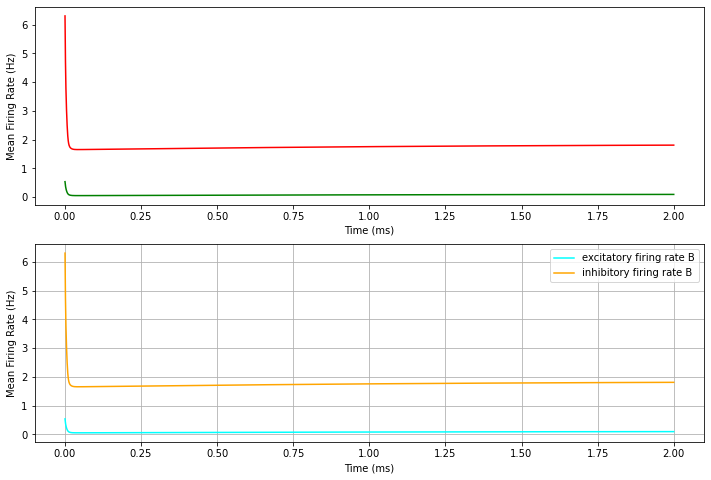

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t_trace, ve1[1:], color="green", label="excitatory firing rate A")
axs[0].plot(t_trace, vi1[1:], color="red", label="inhibitory firing rate A")
axs[1].plot(t_trace, ve1[1:], color="cyan", label="excitatory firing rate B")
axs[1].plot(t_trace, vi2[1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

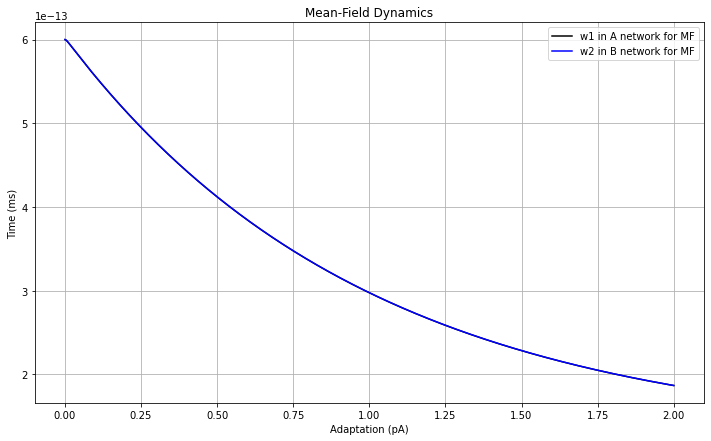

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace,w1[1:],color="black",label="w1 in A network for MF")
plt.plot(t_trace,w2[1:],color="blue",label="w2 in B network for MF")
#for a in range(len(LVG1)):
    #plt.plot(Lt2G2/400,LwG2[a],color="blue",ls='--',label="w1 in A for Adex")
#for a in range(len(LVG3)):
    #plt.plot(Lt2G4/400,LwG4[a],color="black",ls='--',label="w2 in A for Adex")

plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

In [10]:
delays=np.zeros((4,4))
#delays[0][3]=delays[1][2]=0.001 #proche  #delays[0][1]=delays[1][0]
delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005 #delai colonne distantes entre exc-inh et exc-exc colonnes diff
#print(delays)

In [19]:
np.random.seed(10)
x0=final_state.copy()
x0[0]+=0.5
x0[1]+=0.5
print(x0)
#time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=max_delay
    
for i in np.arange(0,2,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())

[5.97156094e-01 5.97156091e-01 1.81067163e+00 1.81067164e+00
 2.06898535e-03 7.57421854e-04 3.37511027e-03 4.37970290e-03
 7.57421854e-04 2.06898530e-03 4.37970278e-03 3.37511021e-03
 3.37511027e-03 4.37970278e-03 4.06717561e-02 1.43361342e-02
 4.37970290e-03 3.37511021e-03 1.43361342e-02 4.06717564e-02
 3.13026835e-12 3.13026835e-12]
Max delay =  0.0
[5.97156094e-01 5.97156091e-01 1.81067163e+00 1.81067164e+00
 2.06898535e-03 7.57421854e-04 3.37511027e-03 4.37970290e-03
 7.57421854e-04 2.06898530e-03 4.37970278e-03 3.37511021e-03
 3.37511027e-03 4.37970278e-03 4.06717561e-02 1.43361342e-02
 4.37970290e-03 3.37511021e-03 1.43361342e-02 4.06717564e-02
 3.13026835e-12 3.13026835e-12]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [20]:
final_state1=x_trace_RS[-1]
print(final_state1)

[1.96220558e+02 1.96220558e+02 1.96220558e+02 1.96220558e+02
 4.66887181e-02 3.36622313e-04 5.87614130e-04 1.71032460e-04
 3.36622313e-04 4.66887181e-02 1.71032460e-04 5.87614131e-04
 5.87614130e-04 1.71032460e-04 1.86237691e-01 5.44261359e-06
 1.71032460e-04 5.87614131e-04 5.44261359e-06 1.86237691e-01
 3.37077032e-09 3.37076897e-09]


In [22]:
np.save('x_trace_b1_5ms.py',x_trace_RS)
np.save('TF_trace_b1_5ms.py',TF_trace_RS)

In [21]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]
vi1=x_transp[2]
vi2=x_transp[3]#[1000:]
w1=x_transp[20]
w2=x_transp[21]

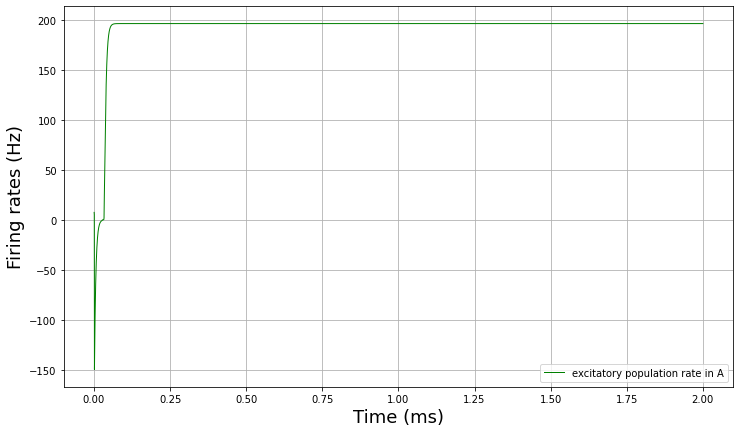

In [22]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve1[steps+1:],color="green",lw="1",label="excitatory population rate in A")
#ax.plot(t_trace,vi1[steps+1:],color="red",lw="1",label="inhibitory population rate in A")
#ax.plot(t_trace,ve2[steps+1:],color="cyan",lw="1",label="excitatory population rate in B")
#ax.plot(t_trace,vi2[steps+1:],color="orange",lw="1",label="inhibitory population rate in B")




ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
#ax.set_xlim(2,3)
#ax.show()

In [37]:
np.arange(6e-10,1e-9,1e-10)

array([6.e-10, 7.e-10, 8.e-10, 9.e-10, 1.e-09])

In [28]:
final_state

array([1.23344646e-01, 1.23344649e-01, 1.90671116e+00, 1.90671114e+00,
       3.06068670e-03, 1.35479757e-03, 5.69308087e-03, 6.95008095e-03,
       1.35479757e-03, 3.06068672e-03, 6.95008102e-03, 5.69308093e-03,
       5.69308087e-03, 6.95008102e-03, 5.00882075e-02, 2.31143433e-02,
       6.95008095e-03, 5.69308093e-03, 2.31143433e-02, 5.00882074e-02,
       1.26433806e-13, 1.26433806e-13])

In [68]:
len(np.arange(1e-3,11e-3,1e-3)), len(np.arange(1e-10,1.1e-9,1e-10))

(10, 10)

In [73]:
exciatory_firing_rates = [] 
for delay in np.arange(1e-3,6e-3,1e-3): #refaire np.linspace(5e-10,4.5e-9,5) #espacement de 1
    for qe in np.arange(1e-10,1.1e-9,1e-10):

        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delay
        params['delays'][1][0]=delay
        params['delays'][2][1]=delay
        params['delays'][3][0]=delay

        x0=final_state.copy()
        x0[0]+=0.5
        x0[1]+=0.5
        #t_trace=[]
        x_trace_RS=[]
        #TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=max_delay

        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            #t_trace.append(time)
            x_trace_RS.append(x0.copy())
            #TF_trace_RS.append(TF_inst.copy())
        x_transp=np.transpose(x_trace_RS)
        exciatory_firing_rates.append(max(x_transp[0, steps+1:]))

#############################################
 
 
 sim1 : delay =  0.001  qe =  1e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  2e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  3e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  4e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  5e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  6e-10  
 

####

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  7e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  8e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  9e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  1e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [79]:
np.max(x_transp[:, steps+1:])

19.62768111258931

In [74]:
np.array(exciatory_firing_rates).reshape((5, 10))

array([[1.76722625, 1.76722625, 1.76722625, 1.76722625, 1.76722625,
        1.76722625, 1.76722625, 1.76722625, 1.76722625, 1.76722625],
       [1.23901299, 1.23901299, 1.23901299, 1.23901299, 1.23901299,
        1.23901299, 1.23901299, 1.23901299, 1.23901299, 1.23901299],
       [1.08283909, 1.08283909, 1.08283909, 1.08283909, 1.08283909,
        1.08283909, 1.08283909, 1.08283909, 1.08283909, 1.08283909],
       [1.02415303, 1.02415303, 1.02415303, 1.02415303, 1.02415303,
        1.02415303, 1.02415303, 1.02415303, 1.02415303, 1.02415303],
       [0.98388956, 0.98388956, 0.98388956, 0.98388956, 0.98388956,
        0.98388956, 0.98388956, 0.98388956, 0.98388956, 0.98388956]])

In [44]:
x_transp=np.transpose(x_trace_RS)

In [50]:
len(np.arange(1e-3,6e-3,1e-3)), len(np.arange(6e-10,1e-9,1e-10))

(5, 5)

In [51]:
len(np.arange(0,2,params['tstep']))

4000

In [63]:
exciatory_firing_rate

0.9838895564263808

In [62]:
exciatory_firing_rate = max(x_transp[0, steps+1:])

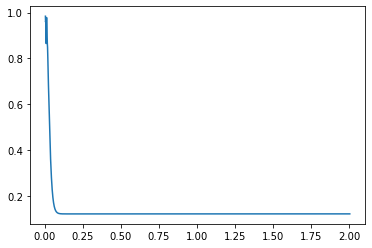

In [61]:
plt.plot(t_trace, x_transp[0, steps+1:])

In [60]:
len(x_transp[0, steps+1:])

4000

In [56]:
len(t_trace)

4000

In [26]:
np.save('x_trace_ok.npy',x_trace_RS)
np.save('TF_trace_ok.npy',TF_trace_RS)

# Perturbation

In [ ]:
AmpStim1=0.5
#Binp=2
def heaviside(x):
    return 0.5 * (1 + np.sign(x))


def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
                      np.exp(-(t - t1_exc) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - t1_exc))
    return inp

'''
input_rate=params['inp_funct']

if (input_rate != 0): input_func=input_rate(t, *params['inp_par'])
else : input_func=0

ji, 1000., 10., 400., AmpStim1))
'''

params['inp_funct']=input_rate # input function
params['inp_par']=[1., 0.02, 0.02, AmpStim1] # input parameters

In [ ]:
np.random.seed(10)
x0=final_state.copy()
#x0[0]+=0.5
print(x0)
time=0
t_trace=[]]
x_trace_RS=[]
TF_trace_RS=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())

In [ ]:
final_state=x_trace_RS[-1]
print(final_state)

In [ ]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]

In [ ]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve[steps+1:],color="green",lw="1",label="excitatory population rate")
ax.plot(t_trace,vi[steps+1:],color="red",lw="1",label="inhibitory population rate")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
ax.set_xlim(2,3)
#ax.show()

### Load network activity to compare with MF

In [77]:
popRateG1=data[0]
popRateG2=data[1]
LwG2=data[2]
LVG1=data[3]
LVG2=data[4]
LfrG1=data[5]
LfrG2=data[6]
TimBinned=data[7]
time_array=data[8]

In [ ]:
trains = M1G1.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

In [8]:
M1G2_list=list(M1G2.i)
M1G4_list=list(M1G4.i)

In [19]:
exc_sp=(M1G2.i)+(M1G4.i[0:60328])
exec_time=(M1G2.t/ms)+(M1G4.t/ms)[0:60328]

No handles with labels found to put in legend.


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

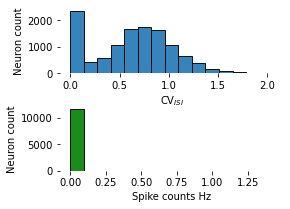

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = exc_sp
times = exec_time
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');#bins=15, alpha=0.9, edgecolor='black'
axs[1].hist(meanFiringRates,bins=15, alpha=0.9, edgecolor='black',color="green");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts Hz")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)
print(meanFiringRates)

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
No h

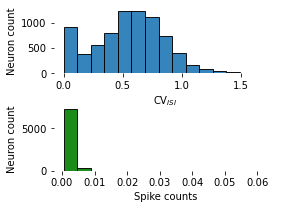

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G4.i
times = M1G4.t/ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates,bins=15, alpha=0.9, edgecolor='black',color="green");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

### Draw distribution

1.0000000000000007e-08 1.1180339887219443e-05 0.5247965918467479 6.491887650492998e-06 0.6390968632923207 0.1490945045420307 4.613344479985466 0.40508183579432433


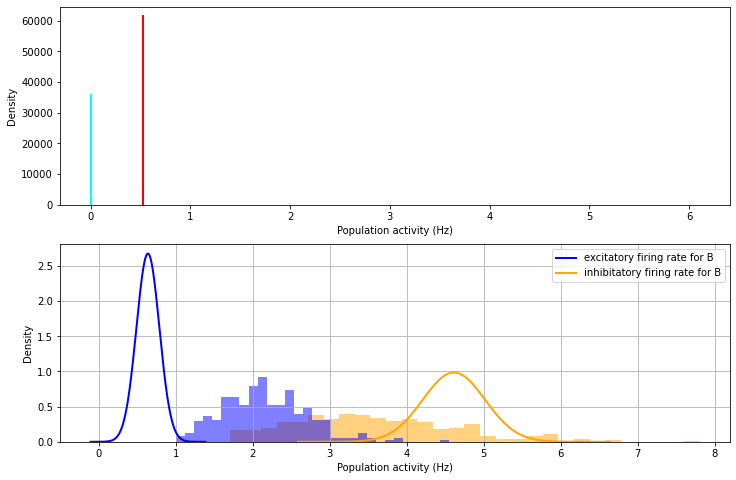

In [20]:
import scipy.stats
import cmath

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]
ST_popRateG3=popRateG3[int(len(popRateG3)/5)::] 
ST_popRateG4=popRateG4[int(len(popRateG4)/5)::]

axs[0].hist(ST_popRateG1, color='red',density= True, bins=30, alpha=0.5)
axs[0].hist(ST_popRateG2, color='cyan',density=True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG3, color='orange',density= True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG4, color='blue',density=True, bins=30, alpha=0.5)


mean_RS1=final_state[0]
std_RS1=np.sqrt(final_state[4])

mean_RS2=final_state[1]
std_RS2=np.sqrt(final_state[9])

mean_FS1=final_state[2]
std_FS1=np.sqrt(final_state[12])

mean_FS2=final_state[3]
std_FS2=np.sqrt(final_state[19])


print(mean_RS1,std_RS1,mean_FS1,std_FS1,mean_RS2,std_RS2,mean_FS2,std_FS2)

x_min_RS1=mean_RS1-5*std_RS1 #x_min_RS=mean_RS-5*std_RS
x_max_RS1=mean_RS1+5*std_RS1

x_min_RS2=mean_RS2-5*std_RS2 #x_min_RS=mean_RS-5*std_RS
x_max_RS2=mean_RS2+5*std_RS2

x_min_FS1=mean_FS1-5*std_FS1
x_max_FS1=mean_FS1+5*std_FS1

x_min_FS2=mean_FS2-5*std_FS2
x_max_FS2=mean_FS2+5*std_FS2

x_RS1 = np.linspace(x_min_RS1, x_max_RS1, 1000)
x_FS1 = np.linspace(x_min_FS1, x_max_FS1, 1000)
x_RS2 = np.linspace(x_min_RS2, x_max_RS2, 1000)
x_FS2 = np.linspace(x_min_FS2, x_max_FS2, 1000)


Distrib_RS1=[]
Distrib_FS1=[]
Distrib_RS2=[]
Distrib_FS2=[]


for i in range(len(x_RS1)):
    Distrib_RS1.append(gaussian(x_RS1[i],mean_RS1,std_RS1))
    Distrib_RS2.append(gaussian(x_RS2[i],mean_RS2,std_RS2))
    Distrib_FS1.append(gaussian(x_FS1[i],mean_FS1,std_FS1))
    Distrib_FS2.append(gaussian(x_FS2[i],mean_FS2,std_FS2))


axs[0].plot(x_RS1,Distrib_RS1,color='cyan',lw=2,label='excitatory firing rate for A')
axs[1].plot(x_RS2,Distrib_RS2,color='blue',lw=2,label='excitatory firing rate for B')
axs[0].plot(x_FS1,Distrib_FS1,color='red',lw=2, label='inhibitatory firing rate for A')
axs[1].plot(x_FS2,Distrib_FS2,color='orange',lw=2, label='inhibitatory firing rate for B')
                             
axs[0].set_xlabel("Population activity (Hz)")
axs[0].set_ylabel("Density")
axs[1].set_xlabel("Population activity (Hz)")
axs[1].set_ylabel("Density")
plt.grid(True)
#plt.ylabel("Density")
plt.legend()
plt.show()

In [43]:
print(x_max_RS)

0.7664898782012017


In [41]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

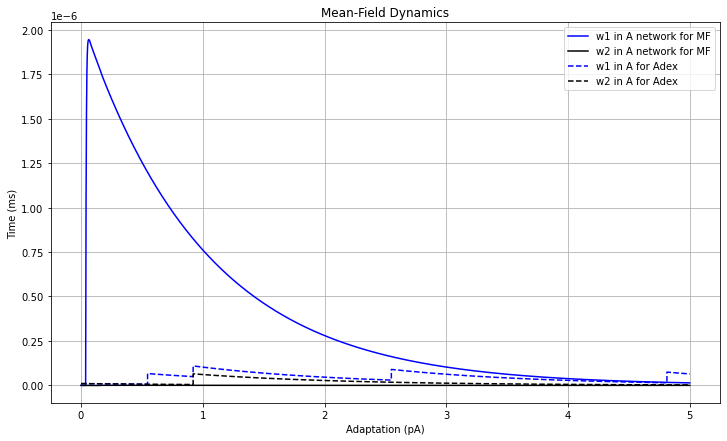

In [22]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitatory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
plt.plot(t_trace,w1,color="blue",label="w1 in A network for MF")
plt.plot(t_trace,w2,color="black",label="w2 in A network for MF")
#for a in range(len(LVG1)):
    #plt.plot(Lt2G2/400,LwG2[a],color="blue",ls='--',label="w1 in A for Adex")
#for a in range(len(LVG3)):
    #plt.plot(Lt2G4/400,LwG4[a],color="black",ls='--',label="w2 in A for Adex")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

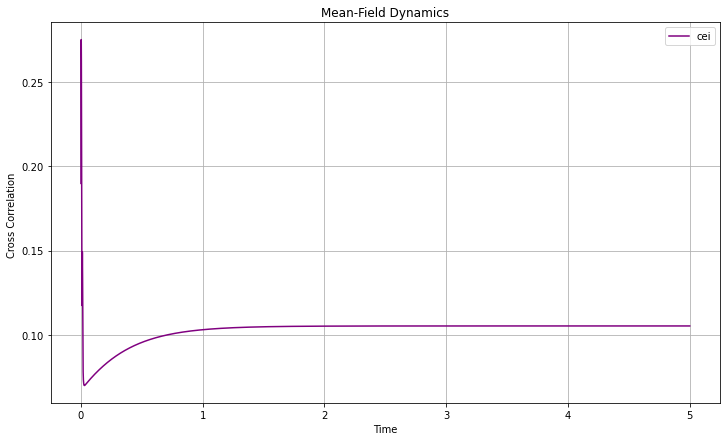

In [20]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
plt.plot(t_trace, ce1i1, color="purple", label="ce1i1")
#plt.plot([-t_trace,t_trace], cie*1e-4, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Cross Correlation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,6000)
#plt.xlim(0,0.1)
plt.show()

In [38]:
load_transfer_functions?

In [37]:
#!/usr/bin/env python
# coding: utf-8

# #### In this code we show how to load and plot the TF of inhibitory and excitatory neuron models


''' We start by loading the necessary components. You can go through the load_transfer_functions routine, although we don't recommend you to spend too much time following the thread, as there are lots of nested structures in this architecture.  '''

import numpy as np
import sys
#sys.path.append('mean_field_adapt')

from transfer_functions.load_config import load_transfer_functions

import matplotlib.pyplot as plt

''' Here we define the so-called configuration (architecture of the network), and the neuron models under considerations. These names (CONFIG1 and RS/FS-cell) refer to sets of parameters defined respecitvely in the files :

- synapses_and_connectivity/syn_and_connec_library.py
- single_cell_models/cell_library.py
'''

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'


TF_temp = load_transfer_functions(NRN1, NRN2, NTWK)


TF=(TF_temp[0],TF_temp[1]) # TF defined as a tuple

current directory is : C:\Users\ASUS\Documents\MyStudies\Simulation - informatique\Najwa\MF
NRN1= RS-cell   NRN2= FS-cell    NTWK= CONFIG1
paramsAAA [-0.04968319  0.00412289 -0.00548494 -0.00134515  0.001      -0.00104587
  0.00306102 -0.00844848 -0.00257167  0.00179862 -0.01382934]


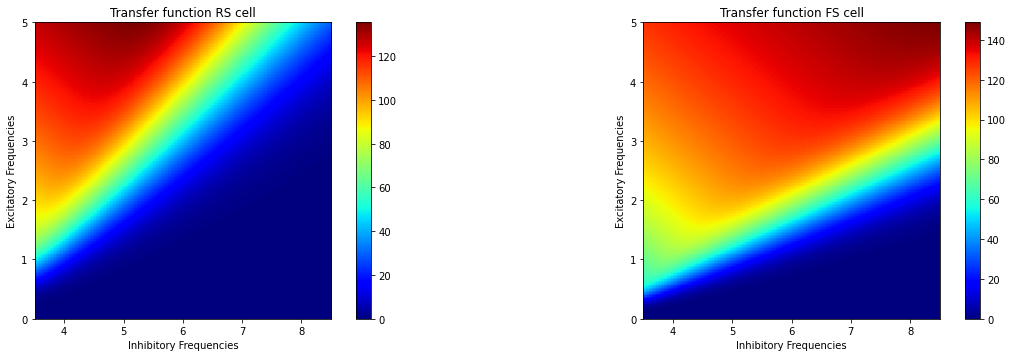

In [39]:
''' Now we want to plot them. The TF under consideration both take three arguments :

- Excitatory input frequency
- Inhibitory input frequency
- Adaptation

All these variables are defined at the population level. That is, they must compare with the population firing rates observable in the network simulations ! Note also that, as no adaptation is considered so far for inhibitory neurons, it is set to zero. '''


### First, build the TFs ###

TF1_test=np.zeros((201,201))
TF2_test=np.zeros((201,201))

for ve in np.linspace(0,200,201):
    for vi in np.linspace(0,200,201):
        #for w in np.linspace(0,200,21):
            
            w=ve/10.*60e-12 ## steady state value according to MF equations, you can try to tune it !
            
            index_ve=int(ve)
            index_vi=int(vi)
            
            #print(ve,vi)
            
            TF1_test[index_ve][index_vi]=TF[0](ve/10,vi/10,w)
            TF2_test[index_ve][index_vi]=TF[1](ve/10,vi/10,0) ## Adaptation for inhibitory population is set to 0
            
            #print('\n \n INPUTS = ',ve,vi,'\n','\n')


### Now plot them ###


fig2=plt.figure(figsize=(20,12))
ax21=fig2.add_subplot(221)
ax22=fig2.add_subplot(222)

#v=np.linspace(0,200,201)
#x,y=np.meshgrid(v,v)

im21=ax21.imshow(TF1_test, cmap='jet',interpolation='nearest',extent=[3.5,8.5,5,0])
ax21.set_ylabel("Excitatory Frequencies")
ax21.invert_yaxis()
ax21.set_xlabel("Inhibitory Frequencies")
ax21.set_title("Transfer function RS cell")
fig2.colorbar(im21, ax=ax21)

im22=ax22.imshow(TF2_test, cmap='jet', interpolation='nearest',extent=[3.5,8.5,5,0])
ax22.set_ylabel("Excitatory Frequencies")
ax22.invert_yaxis()
ax22.set_xlabel("Inhibitory Frequencies")
ax22.set_title("Transfer function FS cell")
fig2.colorbar(im22,ax=ax22)

plt.show()